### Preprocessing and clustering

---
기본 전처리 및 클러스터링 튜토리얼에 사용된 데이터는 "건강한 인간 기증자의 골수 단핵 세포"에서 수집되었으며,
openproblem's NeurIPS 2021 벤치마킹 데이터셋의 일부입니다.

사용된 샘플은 10X Multiome Gene Expression 및 Chromatin Accesability kit를 사용하여 측정되었습니다.

scanpy : 단일 세포 RNA 시퀀싱 데이터를 분석하는 주요 라이브러리

anndata : 데이터를 저장하고 관리하는 객체를 제공

In [14]:
import scanpy as sc
import anndata as ad

pooch : 데이터를 다운로드하고 캐싱하는 데 사용

In [15]:
import pooch

- 목적 : 시각화 설정을 변경하여 그래프와 해상도와 배경색을 설정

In [16]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

- 목적 : 예제 데이터를 다운로드하고 캐싱함
- **figshare** 에서 제공되는 데이터셋을 사용함.

In [17]:
# install Example Data
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_turtorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/"
)
EXAMPLE_DATA.load_registry_from_doi()

In [18]:
samples = {
    "s1d1" : "s1d1_filtered_feature_bc_matrix.h5",
    "s1d2" : "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

adata

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d2    8340
Name: count, dtype: int64


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

- 목적 : 여러 샘플 데이터를 로드하고 병합함.
- 핵심 : **sc.read_10x_h5** : 10x Genomics 형식의 데이터를 읽는다.
- ad.concat : 여러 샘플을 하나의 AnnData 객체로 병합함.

## 품질 관리 (QC)

미토콘드리아 (MT-), 리보솜(RPS, RPL), 헤모글로빈(HB) 유전자를 식별한다.

In [19]:
# mitochondrail genes, "MT-" for humna, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

- QC 매트릭 (미토콘드리아, 리보솜, 헤모글로빈 유전자 비율)을 계산

In [20]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

- QC 메트릭을 violin plot 으로 시각화한다.

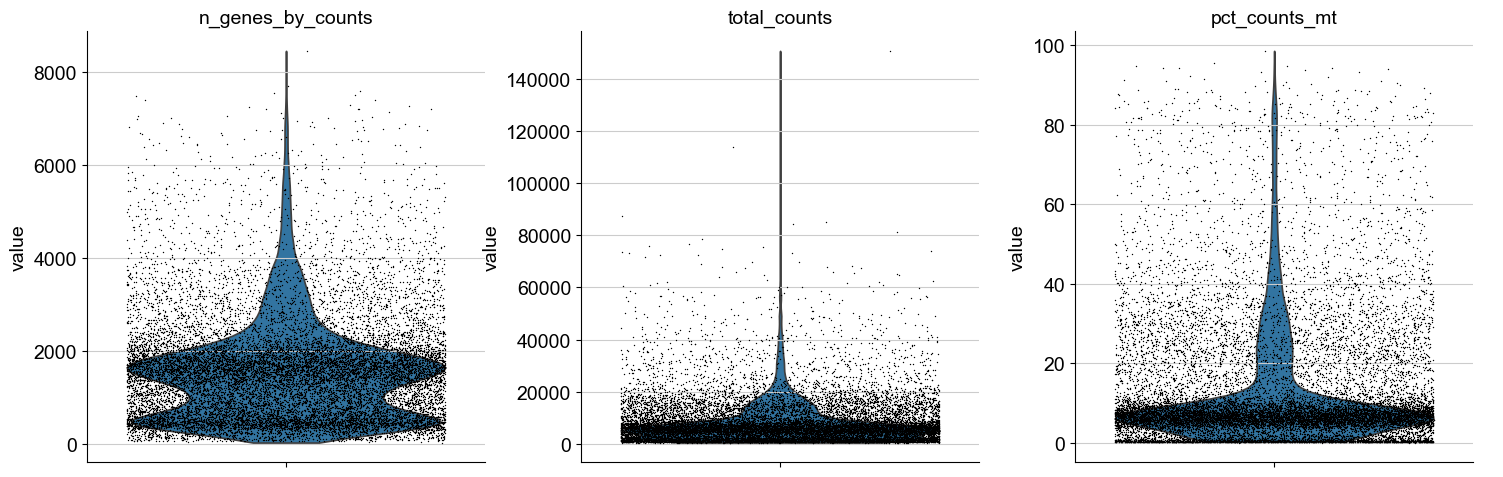

In [21]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts","pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

미토콘드리아 유전자 발현 비율 상위 5개

In [22]:
print(adata.obs["pct_counts_mt"].head())

AAACCCAAGGATGGCT-1     5.309938
AAACCCAAGGCCTAGA-1    13.926710
AAACCCAAGTGAGTGC-1    35.622318
AAACCCACAAGAGGCT-1     4.496973
AAACCCACATCGTGGC-1    28.648647
Name: pct_counts_mt, dtype: float32


총 발현량과 유전자 수를 산점도로 시각화

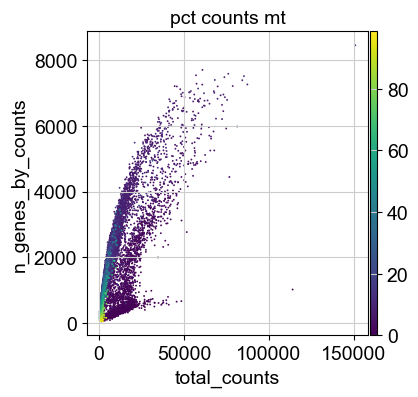

In [23]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

최소 유전자 수와 최소 세포 수 기준으로 데이터 필터링한다.

In [24]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

**scrublet** 사용하여 이중 세포 (doublet)를 감지한다.

In [25]:
sc.pp.scrublet(adata, batch_key="sample")

## Normalization

원본 데이터를 counts 레이어에 저장한다.

총 발현량을 정규화 (normalize_total) 하고 로그 변환 (log1p)을 수행한다.

In [26]:
adata.layers["counts"] = adata.X.copy()

In [27]:
# Normalizating to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

상위 2000개의 고변이 유전자를 선택하고 시각화한다.

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

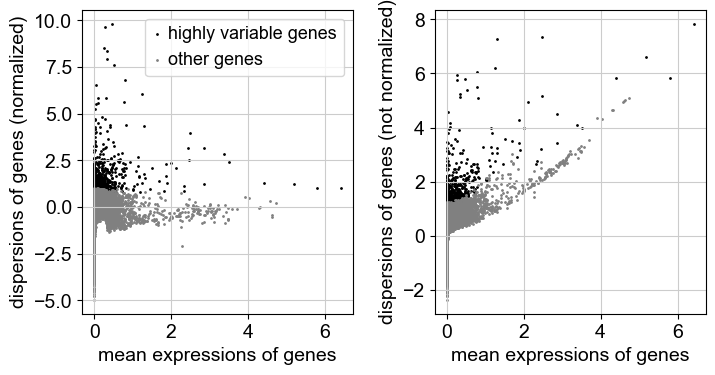

In [29]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

PCA를 수행하고, 주성분의 분산 비율과 결과를 시각화한다.

In [30]:
sc.tl.pca(adata)

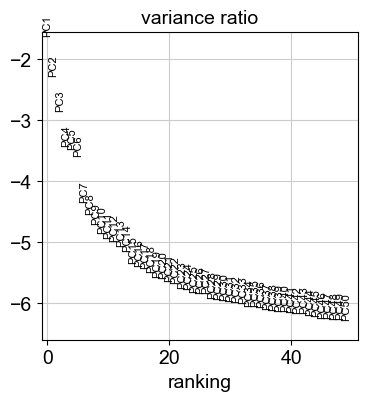

In [31]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

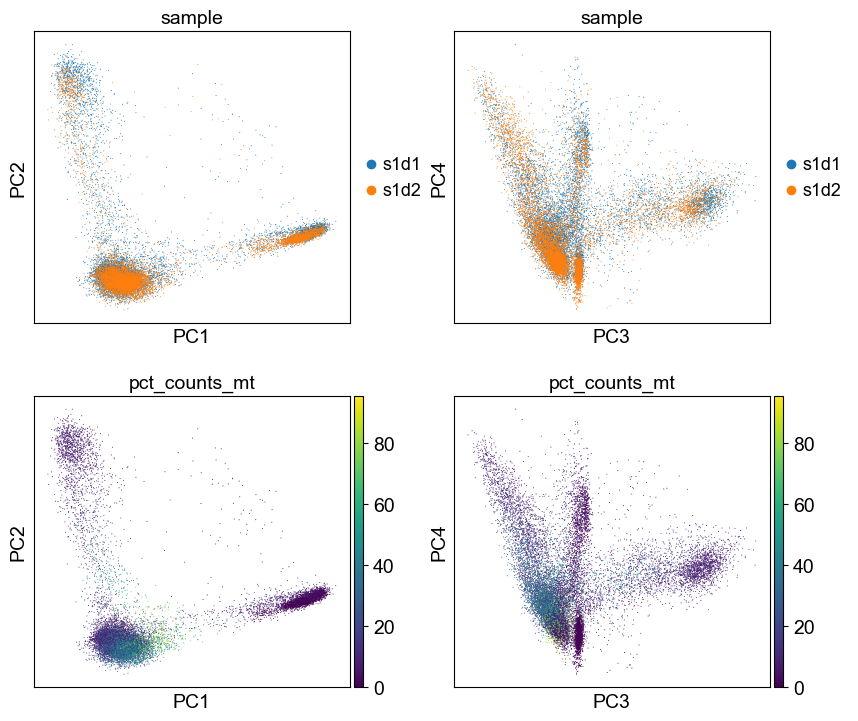

In [32]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

### Nearest neighbor graph construction and visualization

최근접 이웃 그래프를 생성하고, UMAP으로 차원을 축소하여 시각화한다.

In [33]:
sc.pp.neighbors(adata)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
sc.tl.umap(adata)

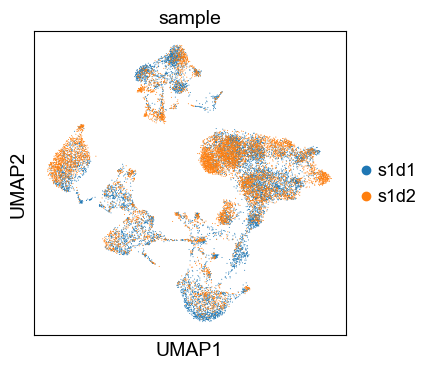

In [35]:
sc.pl.umap(
    adata,
    color='sample',
    # Setting a smaller point size to get prevent overlap
    size=2,
)

### Clustering

Leiden 알고리즘을 사용하여 클러스터링을 수행하고 결과를 UMAP에 시각화한다.

In [36]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

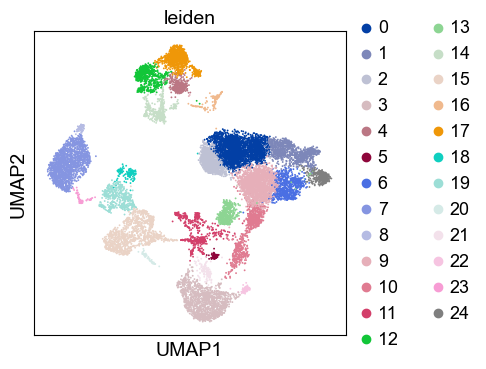

In [37]:
sc.pl.umap(adata, color='leiden')

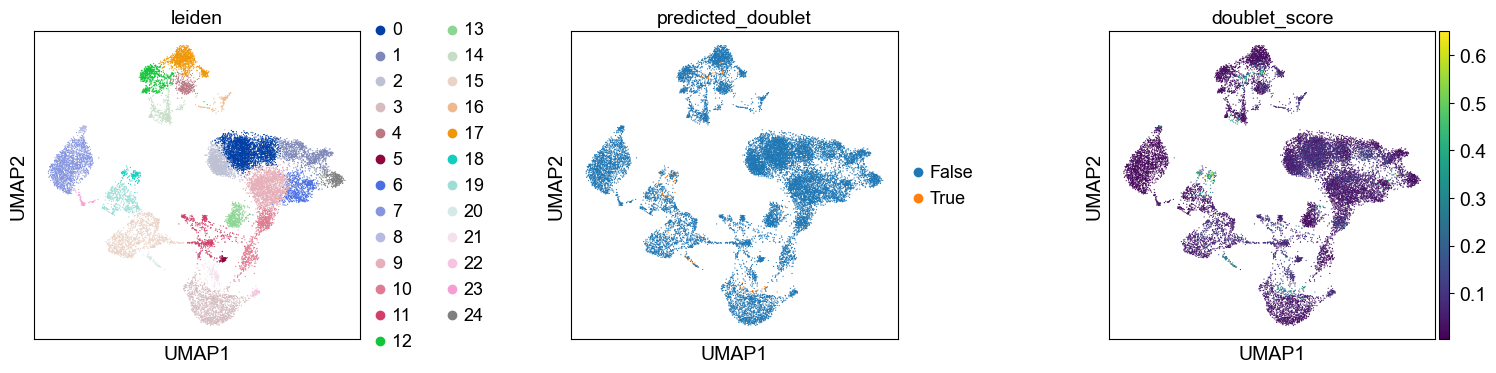

In [38]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    wspace=0.5,
    size=3,
)

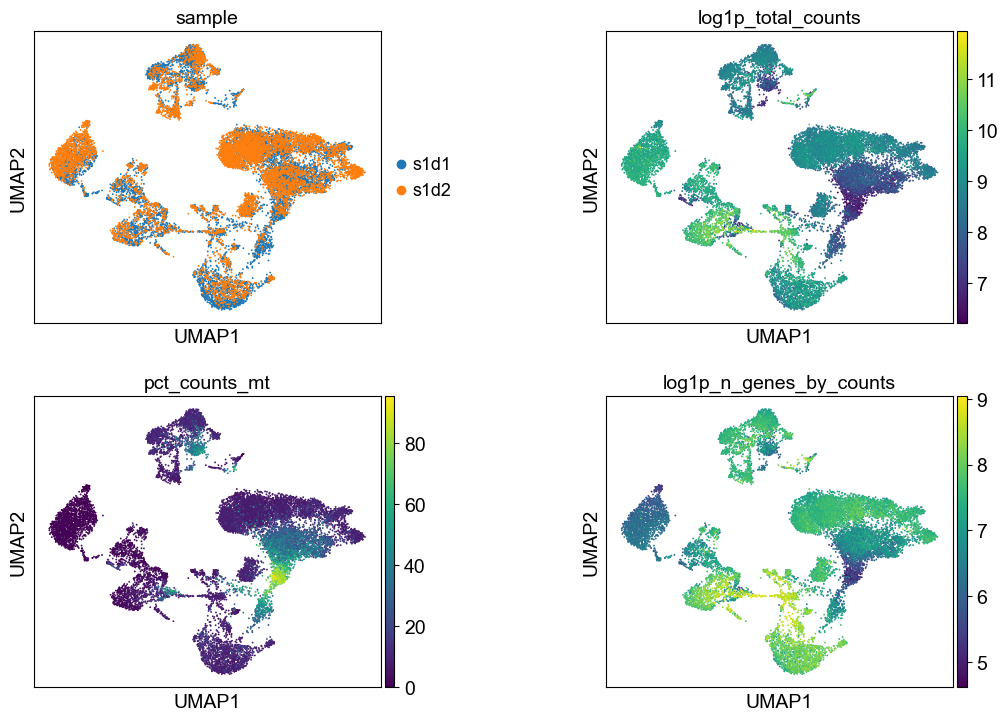

In [39]:
sc.pl.umap(
    adata,
    color=["sample","log1p_total_counts","pct_counts_mt","log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [40]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

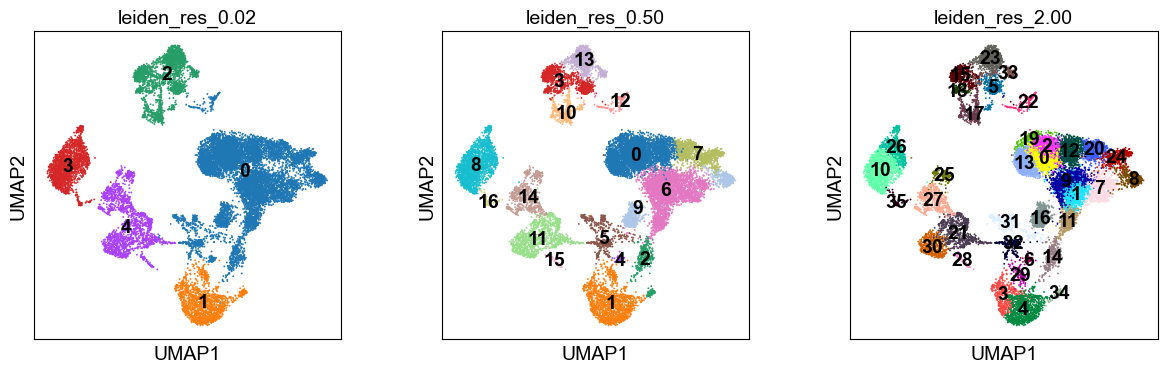

In [41]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

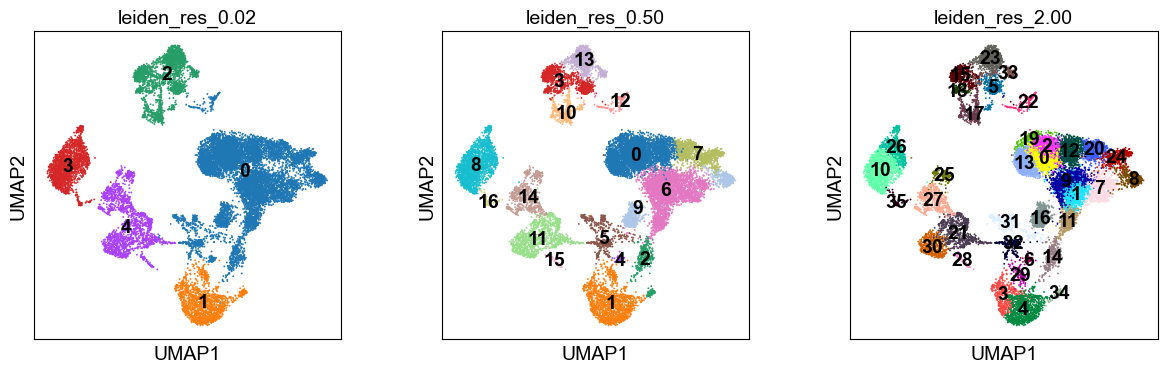

In [42]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

### 마커 유전자 분석
특정 세포 유형의 마커 유전자를 정의하고 dotplot으로 시각화한다.

In [43]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

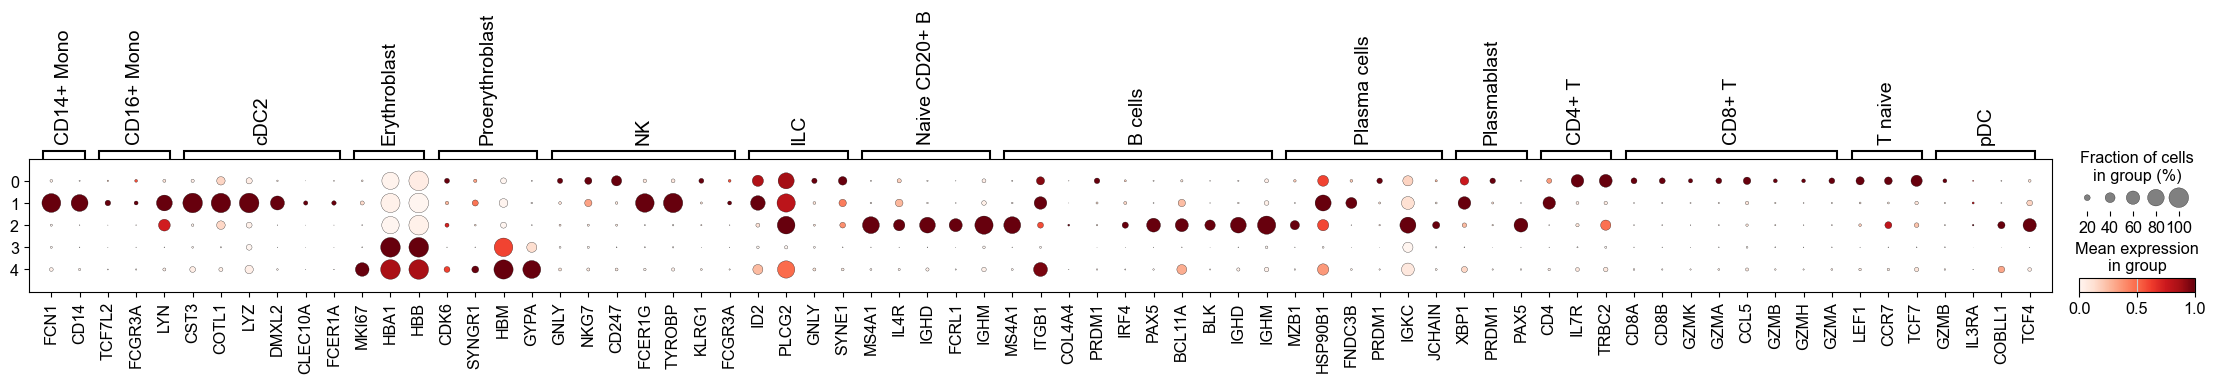

In [44]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

In [45]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

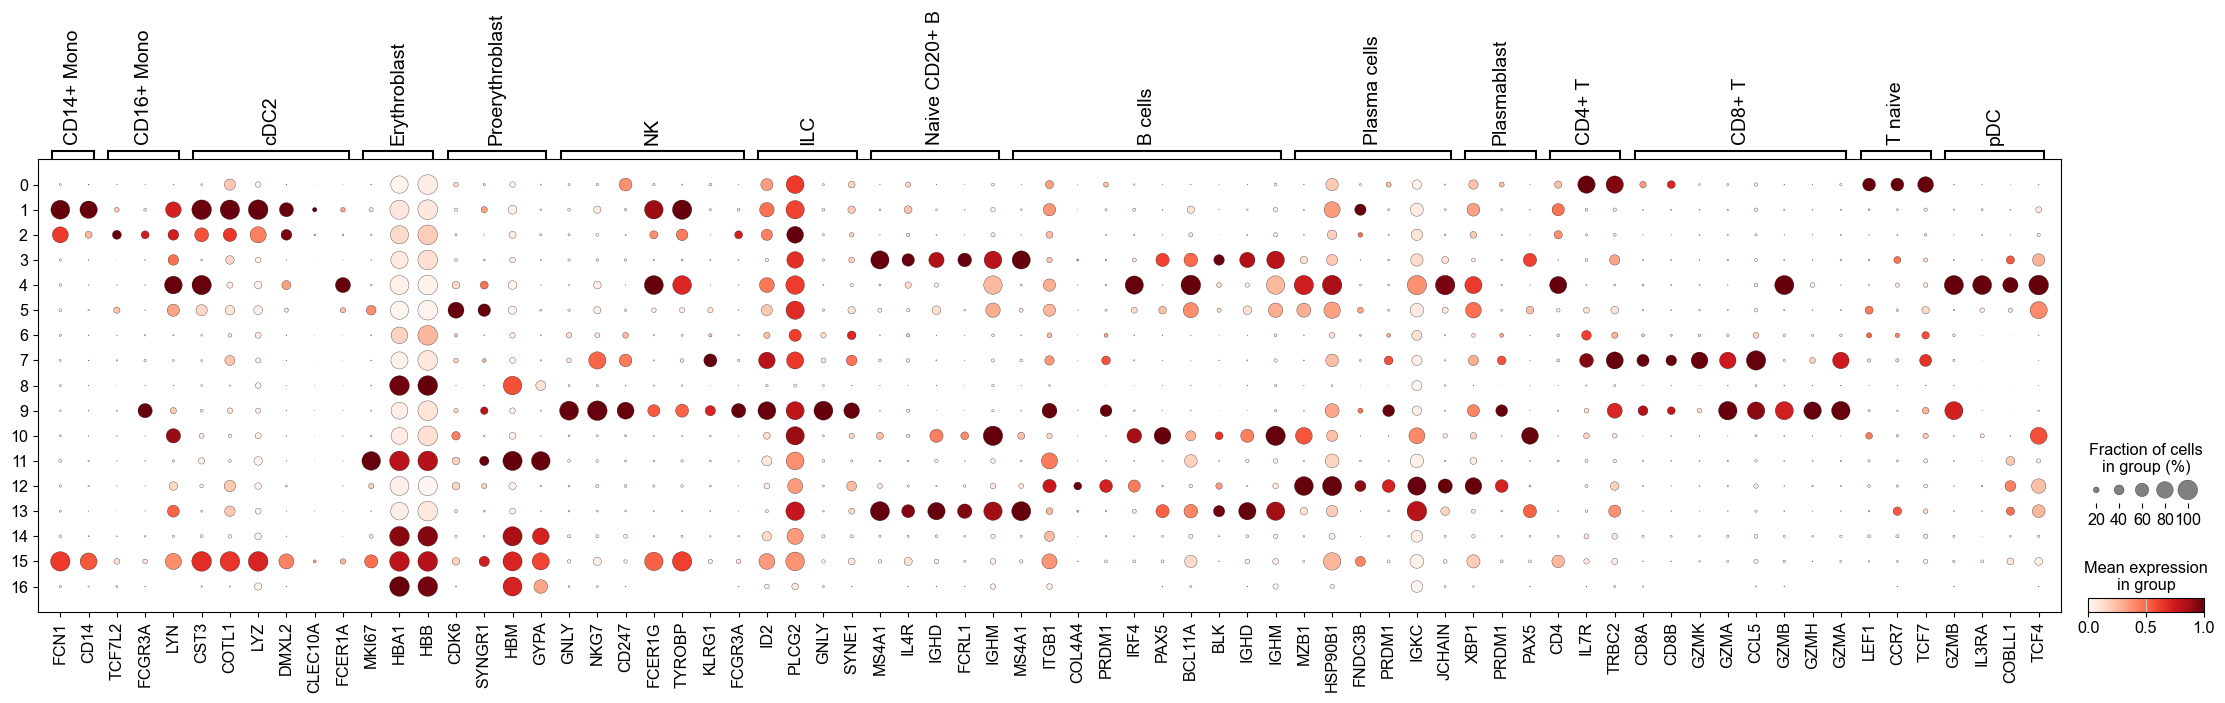

In [46]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

### Differentially-expressed Genes as Markers

sc.tl.rank_genes_groups 함수는 클러스터별로 차별적으로 발현된 유전자를 랭킹할 때 사용합니다.


클러스터별 차별적으로 발현된 유전자를 랭킹하고 dotplot으로 시각화한다

In [47]:
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

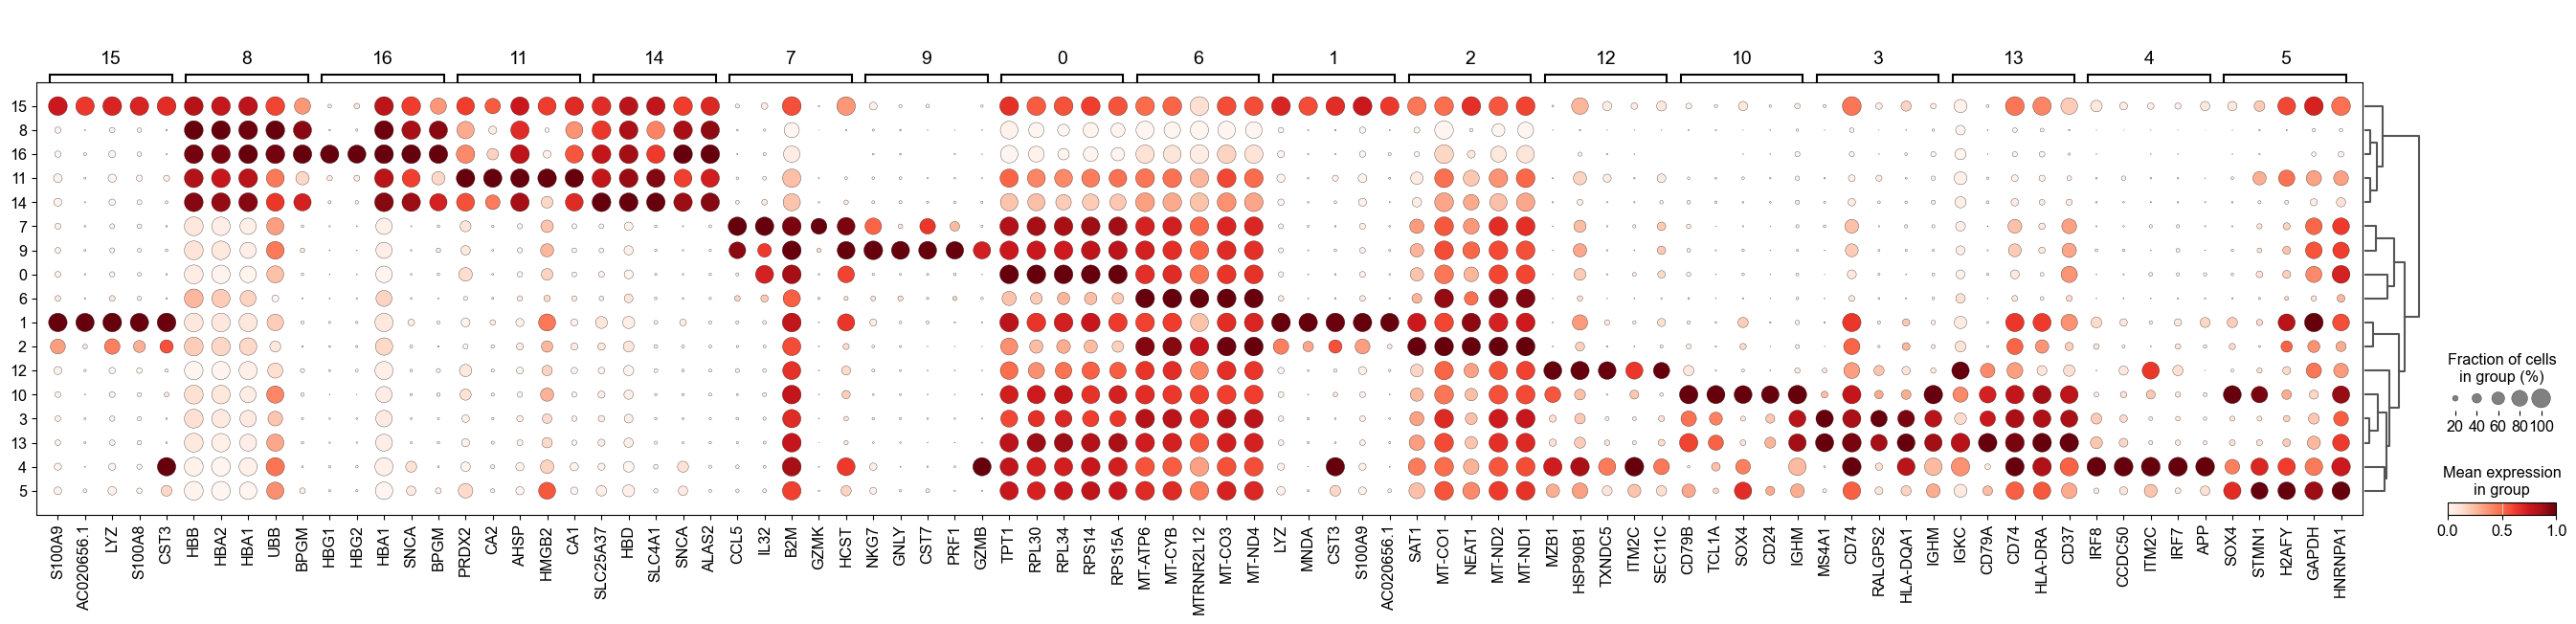

In [48]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

In [49]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CCL5,47.043129,5.492334,0.000000e+00,0.000000e+00
1,IL32,43.149578,3.454962,0.000000e+00,0.000000e+00
2,B2M,40.954205,2.047546,0.000000e+00,0.000000e+00
3,GZMK,40.615395,6.136360,0.000000e+00,0.000000e+00
4,HCST,37.374123,2.657552,1.028846e-305,4.529613e-302


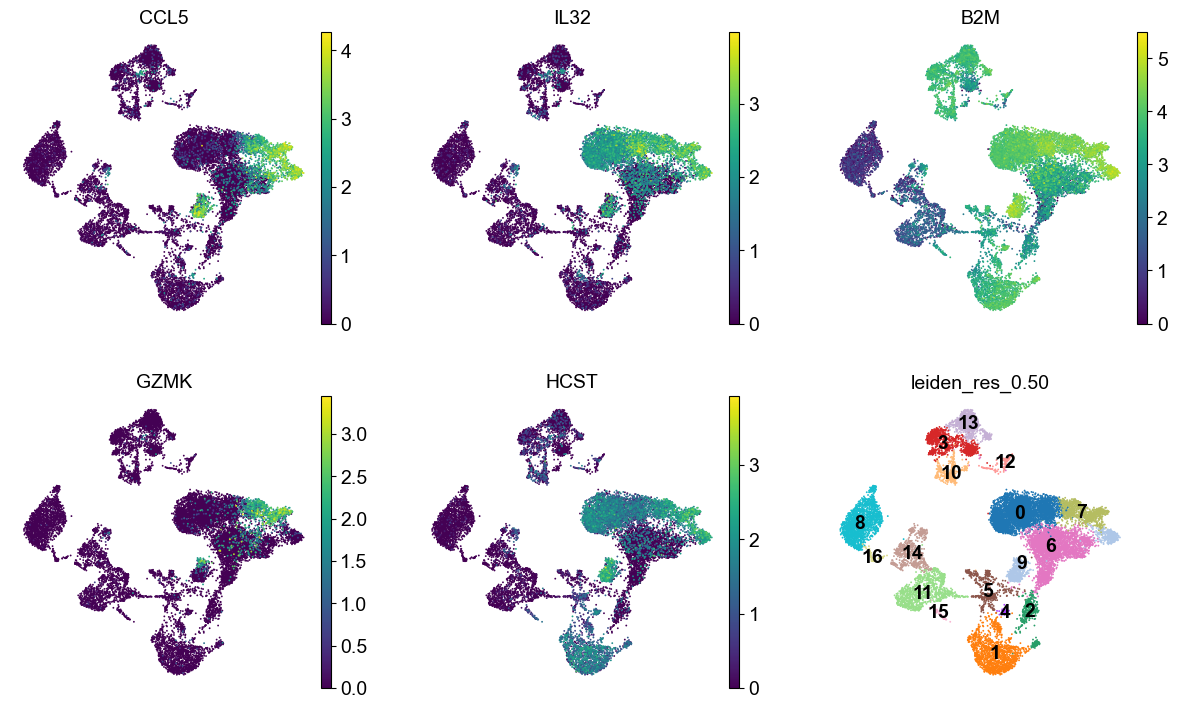

In [50]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)